## eda

https://www.kaggle.com/code/martynovandrey/eda-and-lgb-cat-xgb#%F0%9F%93%8A-EDA

https://www.kaggle.com/code/darkdevil18/0-97356-loan-approval-catboost-ensemble#Distribution-of-Categorical-Features

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Kaggle/lap

/content/drive/MyDrive/Kaggle/lap


In [ ]:
import os
cpu_count = os.cpu_count()
print(f"Number of CPUs: {cpu_count}")

Number of CPUs: 12


In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA L4 (UUID: GPU-adc41918-ccc4-d250-800a-6b8f809f384e)


In [ ]:
import torch
gpu_count = torch.cuda.device_count()
print(f"Number of GPUs: {gpu_count}")

Number of GPUs: 1


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

def create_features(train, test):
    for df in [train, test]:
        df['income_to_age'] = df['person_income'] / df['person_age']
        df['loan_to_income'] = df['loan_amnt'] / df['person_income']
        df['rate_to_loan'] = df['loan_int_rate'] / df['loan_amnt']
        df['age_squared'] = df['person_age'] ** 2
        df['log_income'] = np.log1p(df['person_income'])
        df['age_credit_history_interaction'] = df['person_age'] * df['cb_person_cred_hist_length']
        df['age_category'] = pd.cut(df['person_age'], bins=[0, 25, 35, 45, 55, 100], labels=['Very Young', 'Young', 'Middle', 'Senior', 'Elder'])
        df['income_category'] = pd.qcut(df['person_income'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        df['high_loan_to_income'] = (df['loan_percent_income'] > 0.5).astype(int)
        df['intent_grade_interaction'] = df['loan_intent'].astype(str) + '_' + df['loan_grade'].astype(str)
        df['loan_to_employment'] = df['loan_amnt'] / (df['person_emp_length'] + 1)
        df['is_new_credit_user'] = (df['cb_person_cred_hist_length'] < 2).astype(int)
        df['home_ownership_intent'] = df['person_home_ownership'].astype(str) + '_' + df['loan_intent'].astype(str)
        df['rate_to_grade'] = df.groupby('loan_grade')['loan_int_rate'].transform('mean')
        df['high_interest_rate'] = (df['loan_int_rate'] > df['loan_int_rate'].mean()).astype(int)
        df['risk_score'] = df['loan_percent_income'] * df['loan_int_rate'] * (5 - df['loan_grade'].map({'A':5, 'B':4, 'C':3, 'D':2, 'E':1, 'F':0, 'G':0}))
        df['age_to_credit_history'] = df['person_age'] / (df['cb_person_cred_hist_length'] + 1)
        df['income_home_mismatch'] = ((df['person_income'] > df['person_income'].quantile(0.8)) & (df['person_home_ownership'] == 'RENT')).astype(int)
        df['default_grade_interaction'] = df['cb_person_default_on_file'].astype(str) + '_' + df['loan_grade'].astype(str)
        df['normalized_loan_amount'] = df.groupby('loan_intent')['loan_amnt'].transform(lambda x: (x - x.mean()) / x.std())
        df['income_to_loan'] = df['person_income'] / df['loan_amnt']
        df['age_cubed'] = df['person_age'] ** 3
        df['log_loan_amnt'] = np.log1p(df['loan_amnt'])
        df['age_interest_interaction'] = df['person_age'] * df['loan_int_rate']
        df['loan_amount_category'] = pd.qcut(df['loan_amnt'], q=5, labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'])
        df['credit_history_to_age'] = df['cb_person_cred_hist_length'] / df['person_age']
        df['high_loan_amount'] = (df['loan_amnt'] > df['loan_amnt'].quantile(0.75)).astype(int)
        df['home_ownership_loan_interaction'] = df['person_home_ownership'].astype(str) + '_' + df['loan_amount_category'].astype(str)
        df['rate_to_credit_history'] = df['loan_int_rate'] / (df['cb_person_cred_hist_length'] + 1)
        df['intent_home_match'] = ((df['loan_intent'] == 'HOMEIMPROVEMENT') & (df['person_home_ownership'] == 'OWN')).astype(int)
        df['creditworthiness_score'] = (df['person_income'] / (df['loan_amnt'] * df['loan_int_rate'])) * (df['cb_person_cred_hist_length'] + 1)
        df['age_to_employment'] = df['person_age'] / (df['person_emp_length'] + 1)
        df['age_income_mismatch'] = ((df['person_age'] < 30) & (df['person_income'] > df['person_income'].quantile(0.9))).astype(int)
        df['default_rate_interaction'] = df['cb_person_default_on_file'].astype(str) + '_' + pd.cut(df['loan_int_rate'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']).astype(str)
        df['normalized_income'] = df.groupby('age_category')['person_income'].transform(lambda x: (x - x.mean()) / x.std())
        df['rate_to_age'] = df['loan_int_rate'] / df['person_age']
        df['high_risk_flag'] = ((df['loan_percent_income'] > 0.4) &
                                (df['loan_int_rate'] > df['loan_int_rate'].mean()) &
                                (df['cb_person_default_on_file'] == 'Y')).astype(int)

        num_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income']
        poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
        poly_features = poly.fit_transform(df[num_features])

        try:
            poly_features_names = poly.get_feature_names_out(num_features)
        except AttributeError:
            poly_features_names = poly.get_feature_names(num_features)

        for i, name in enumerate(poly_features_names[len(num_features):]):
            df[f'poly_{name}'] = poly_features[:, len(num_features) + i]

        df['age_sin'] = np.sin(2 * np.pi * df['person_age'] / 100)
        df['age_cos'] = np.cos(2 * np.pi * df['person_age'] / 100)
        df['stability_score'] = (df['person_emp_length'] * df['person_income']) / (df['loan_amnt'] * (df['cb_person_cred_hist_length'] + 1))

    return train, test

train, test = create_features(train, test)

In [ ]:
# https://www.kaggle.com/code/darkdevil18/0-97362-loan-approval-catboost-ensemble#Handling-Missing-Values

In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/data/train.csv', index_col='id')
test = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/data/test.csv', index_col='id')
origin = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/data/credit_risk_dataset.csv')

In [ ]:
origin.describe()

In [ ]:
origin.info()

In [ ]:
origin.duplicated().sum()

165

In [ ]:
##
origin.drop_duplicates(inplace=True)

In [ ]:
origin.isna().sum()

In [ ]:
origin['loan_int_rate'] = origin['loan_int_rate'].fillna(origin['loan_int_rate'].mean())
origin['person_emp_length'] = origin['person_emp_length'].fillna(origin['person_emp_length'].mean())

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
from IPython.display import display, HTML

warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.base import clone

from catboost import CatBoostClassifier, Pool

In [ ]:
target = 'loan_status'

In [ ]:
features = origin.drop(target, axis=1).columns.tolist()

In [ ]:
categorical_features = origin.select_dtypes(include='object').columns.tolist()

In [ ]:
numerical_features = list(set(features) - set(categorical_features))

In [ ]:
origin.describe().T

In [ ]:
origin[categorical_features].describe(include='O').T

In [ ]:
for col in categorical_features:
    display(origin.groupby(col)[['loan_amnt', 'loan_int_rate']].agg(['min', 'mean', 'max']))

In [ ]:
def feature_distribution_plot(df, col, target_col=None):
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    if df[col].dtype != 'object':
        sns.histplot(data=df, x=col, hue=target_col)
    else:
        sns.countplot(data=df, x=col, hue=target_col)
    plt.ylabel('Count')
    plt.xlabel(f'{col}')
    plt.title(f'Histogram of {col}')

    plt.subplot(1,2,2)
    if df[col].dtype != 'object':
        sns.boxplot(data=df, x=col, hue=target_col)
        plt.title(f'Boxplot of {col}')
        plt.ylabel('Count')
        plt.xlabel(f'{col}')
    else:
        df[col].value_counts().plot(kind='pie', autopct='%.0f%%',pctdistance=0.85,fontsize=12)
        plt.gca().add_artist(plt.Circle((0,0),radius=0.7,fc='white'))
        plt.title(f'Pie Chart of {col}')
        plt.xlabel('')
        plt.ylabel('')


    plt.tight_layout()
    plt.suptitle(f'Distribution of {col}', y=1.05, size=24, weight='bold')
    plt.show()

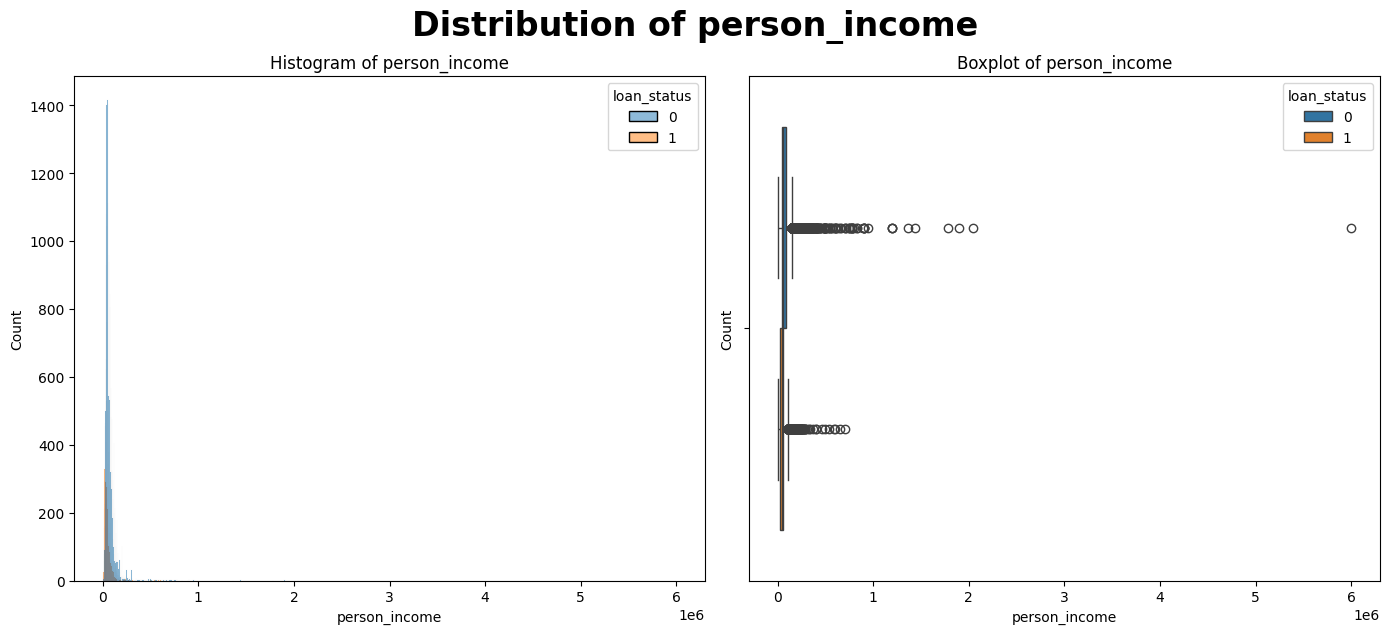

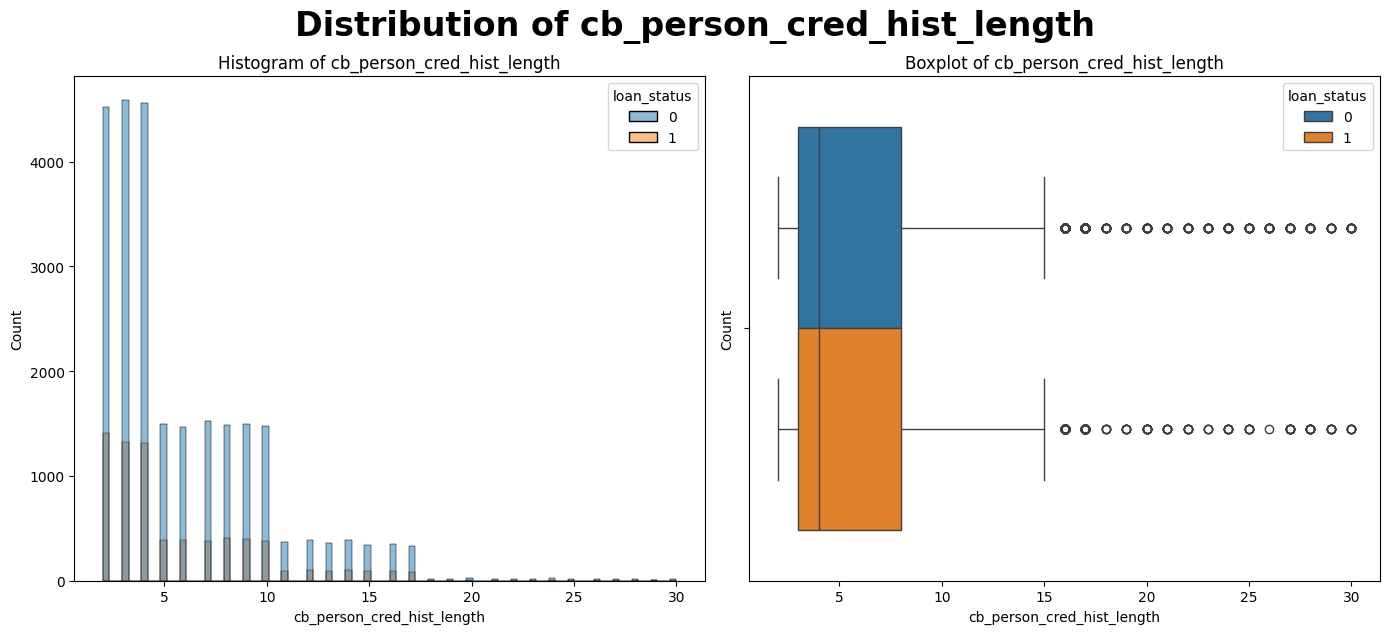

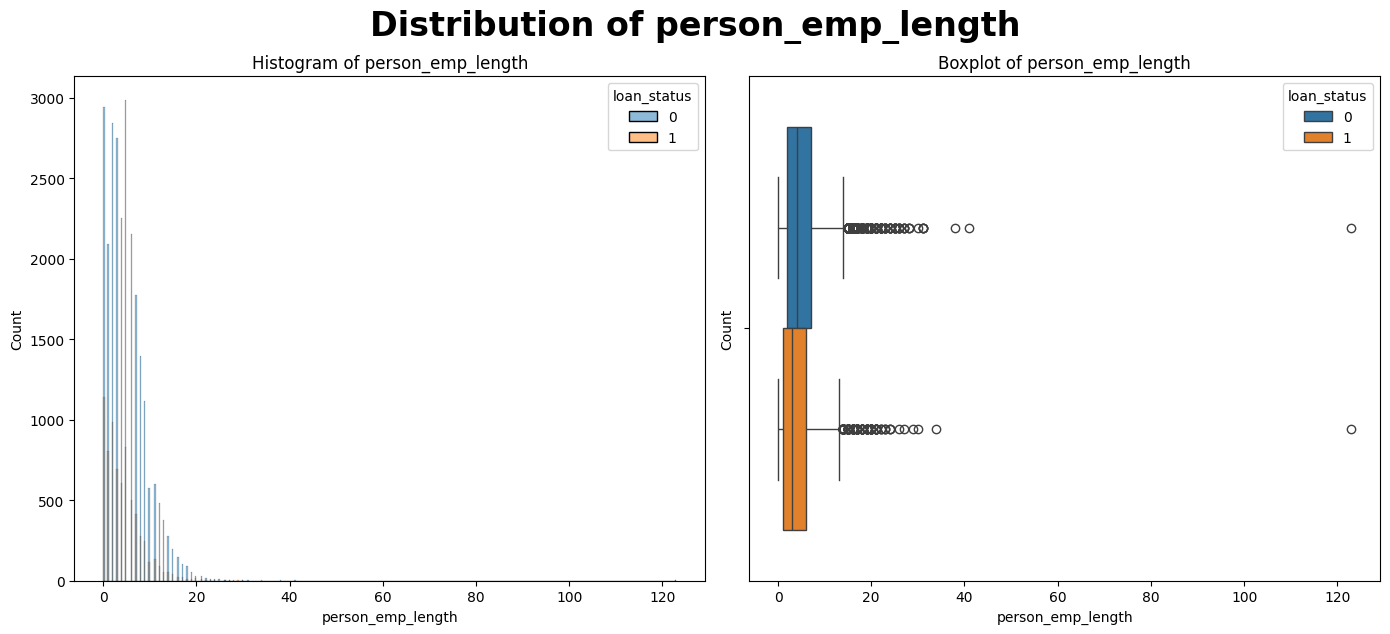

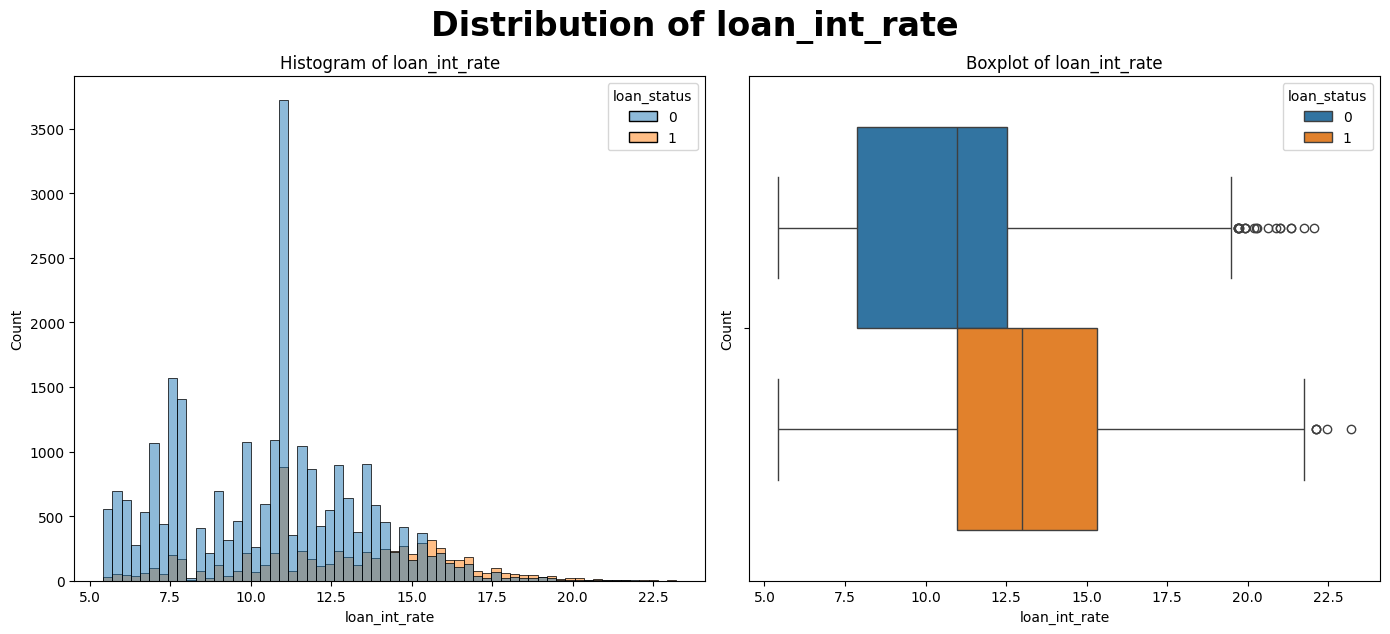

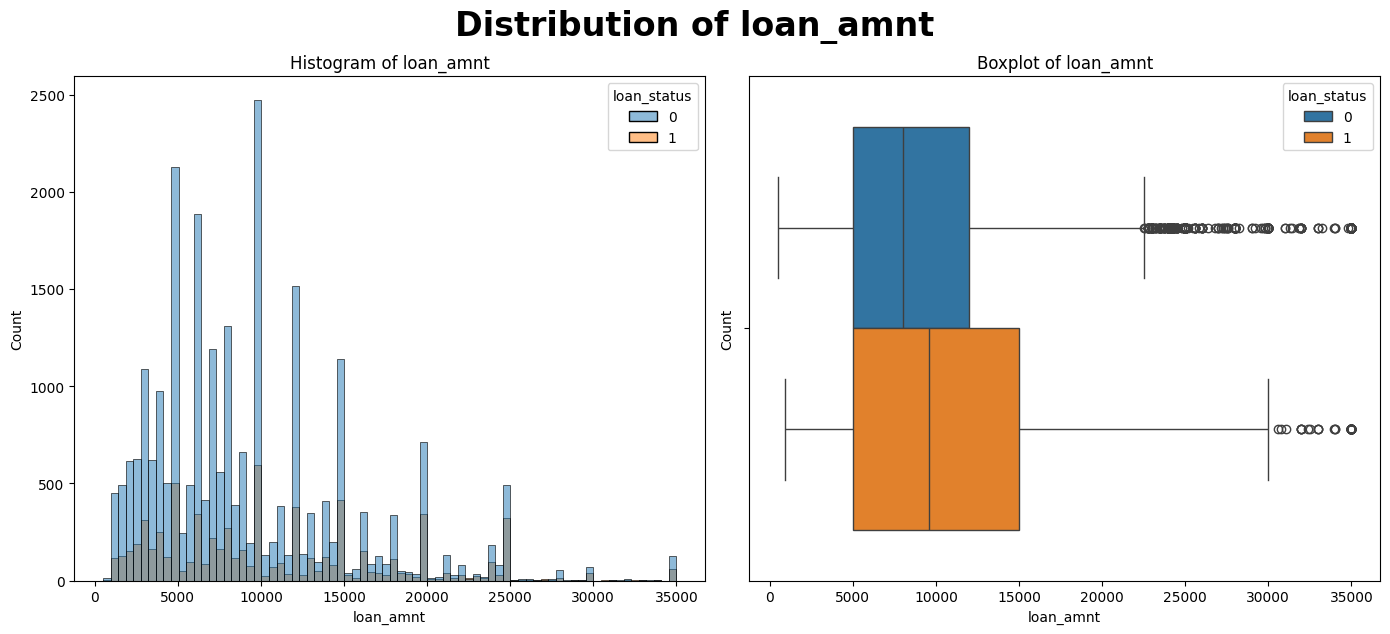

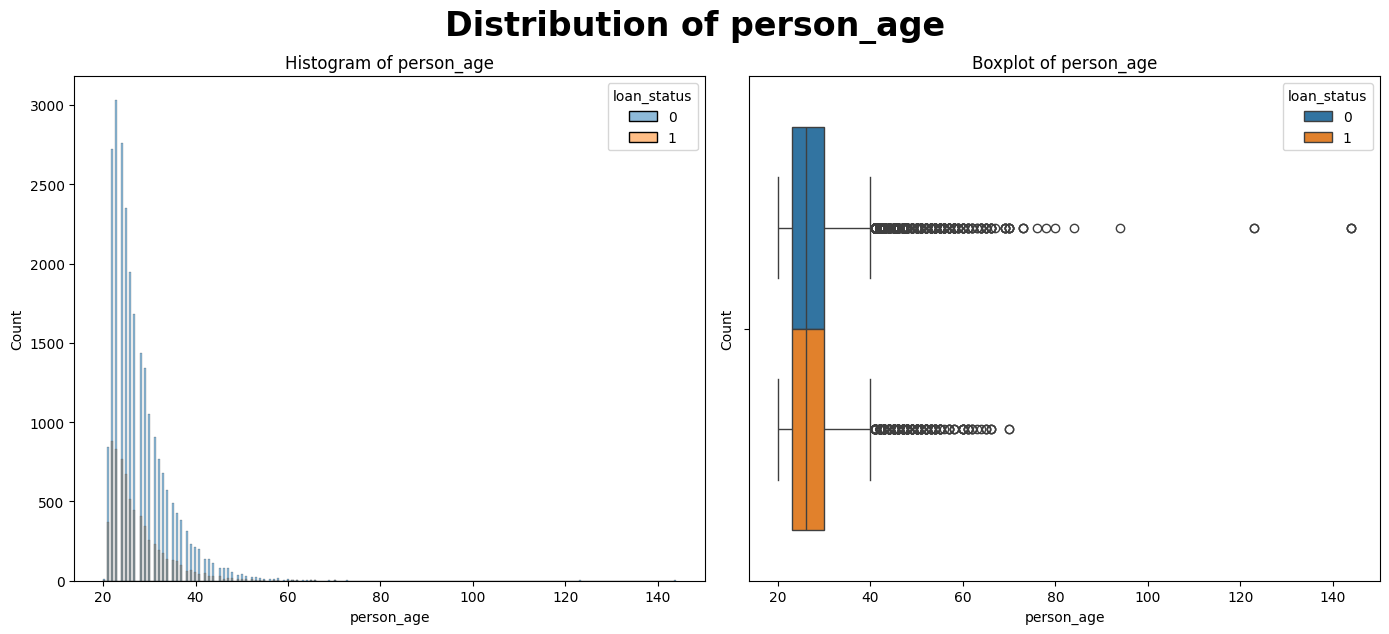

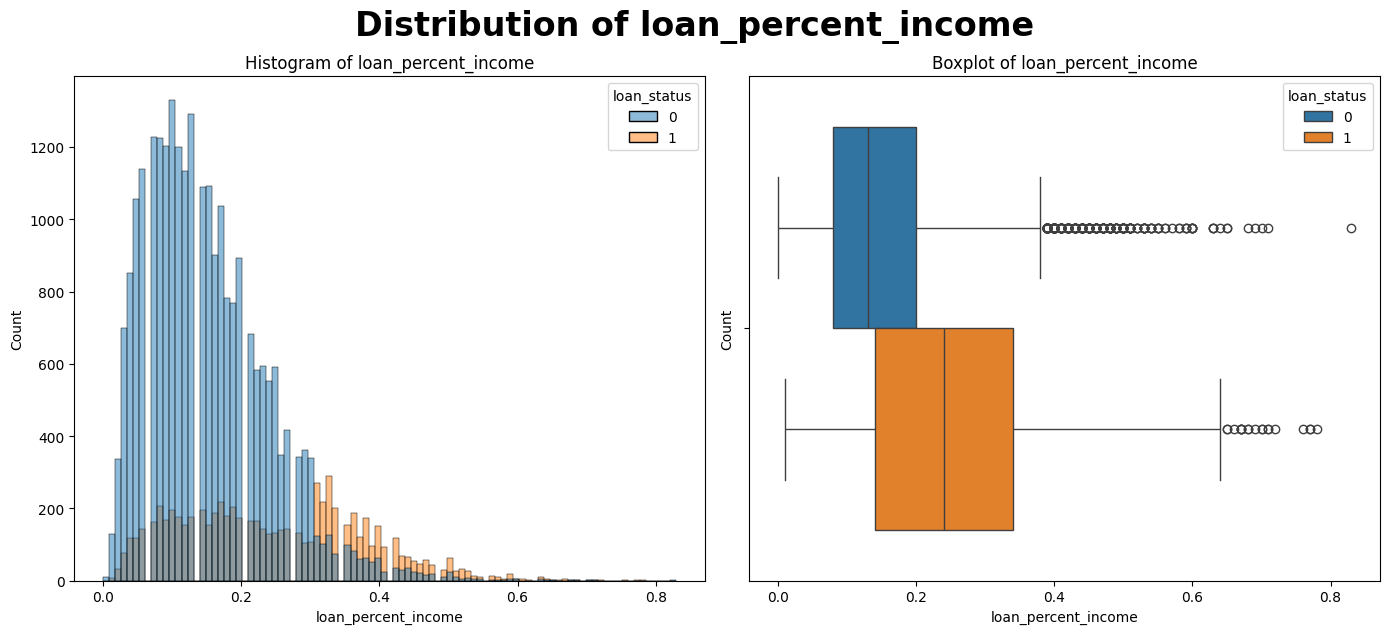

In [ ]:
for col in numerical_features:
    feature_distribution_plot(origin, col, target)

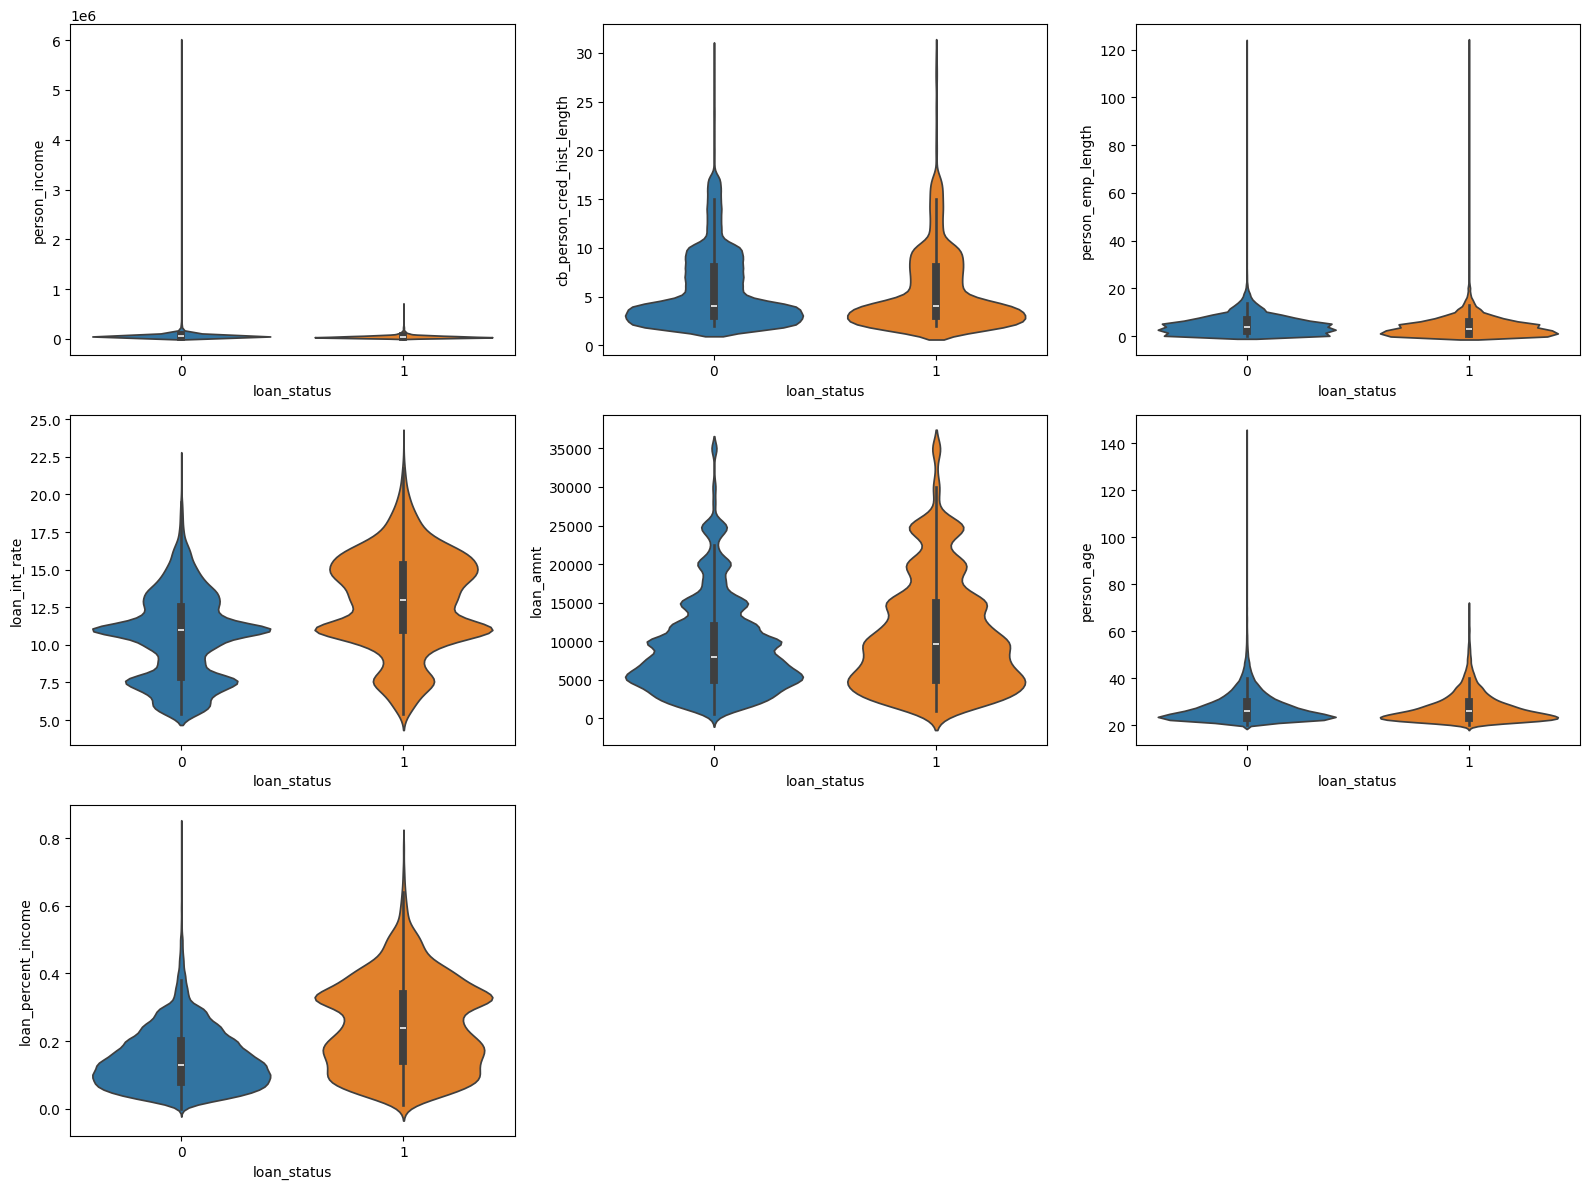

In [ ]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.violinplot(origin, x=target, y=col, hue=target, legend=None)

plt.tight_layout()
plt.show()

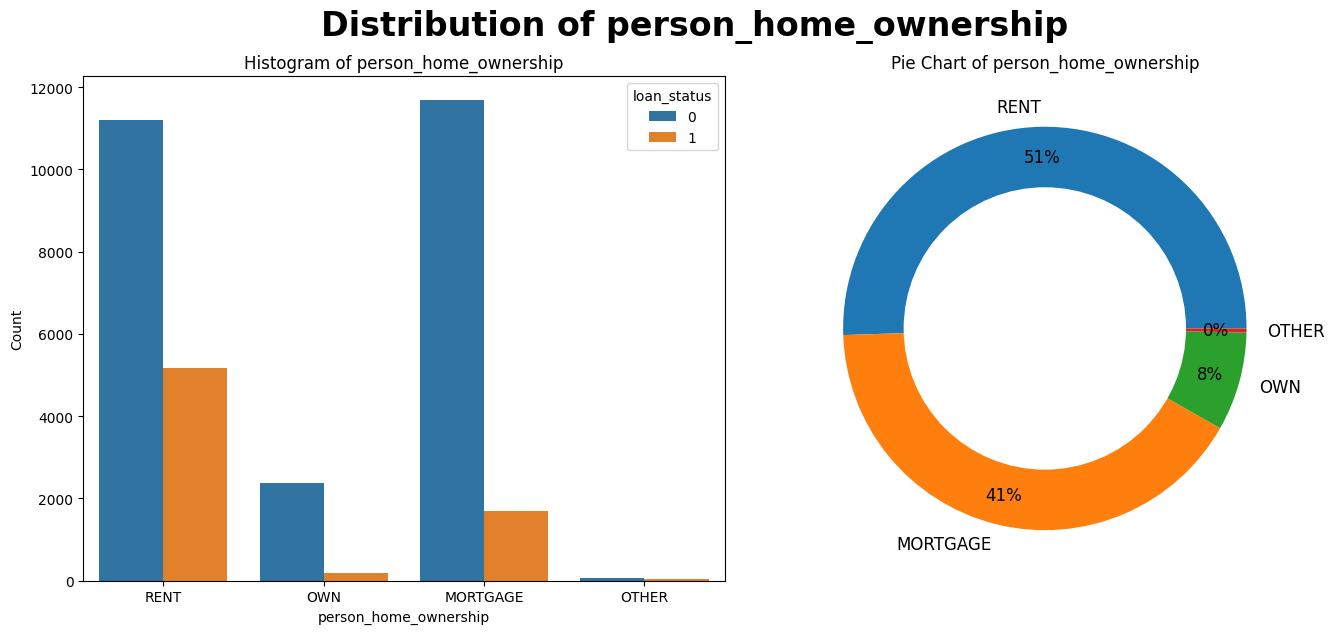

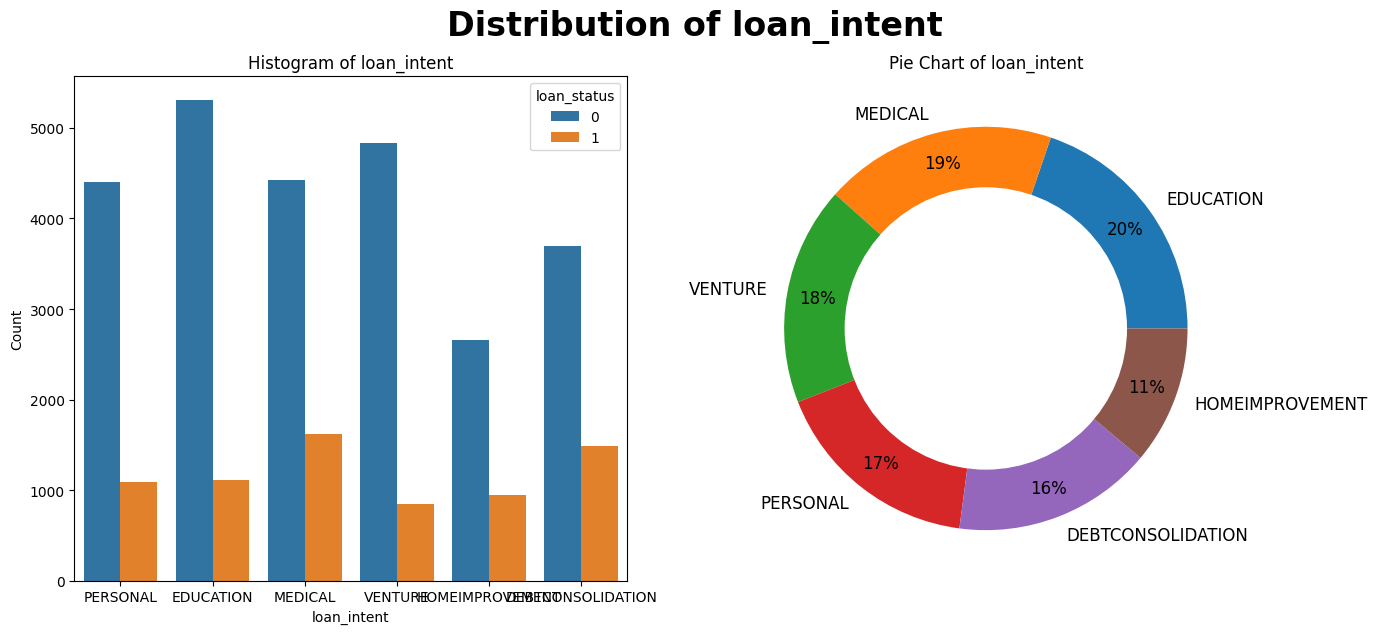

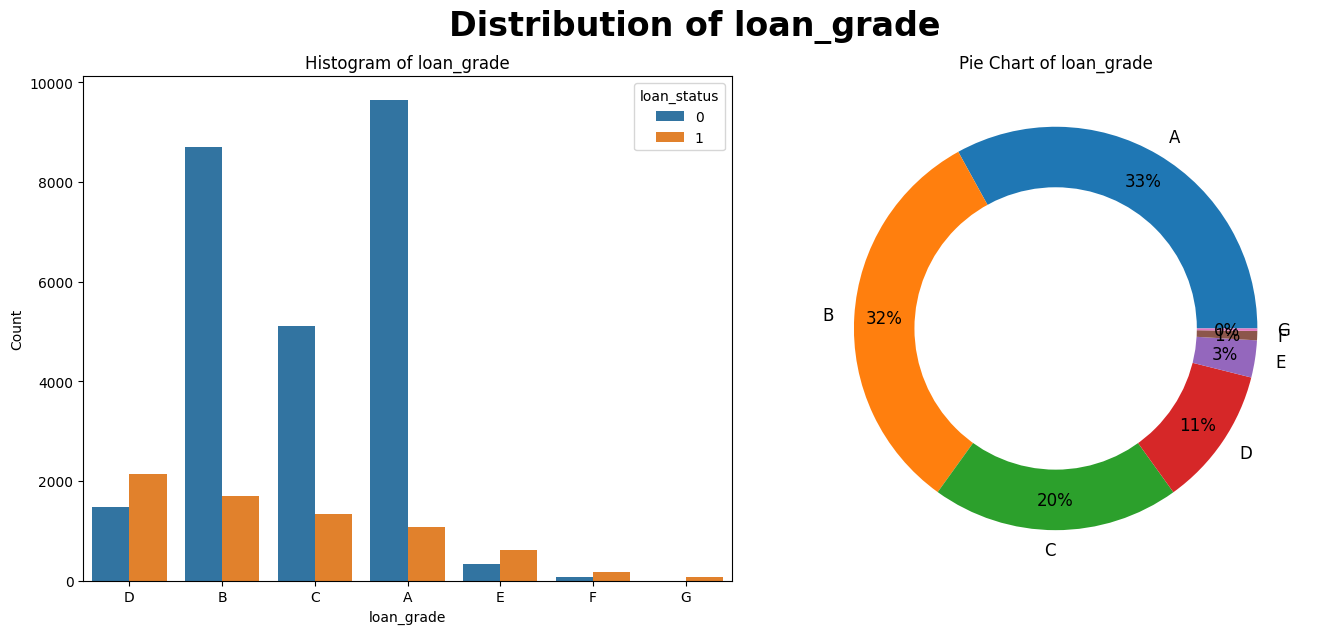

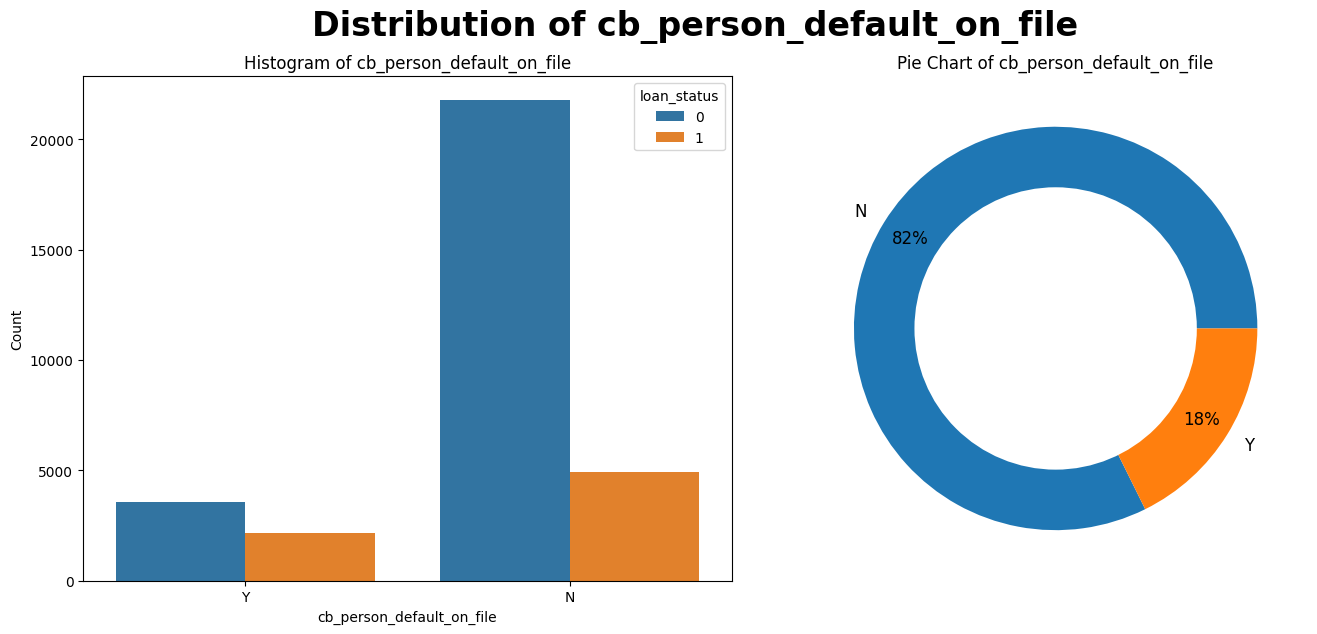

In [ ]:
for col in categorical_features:
    feature_distribution_plot(origin, col, target)

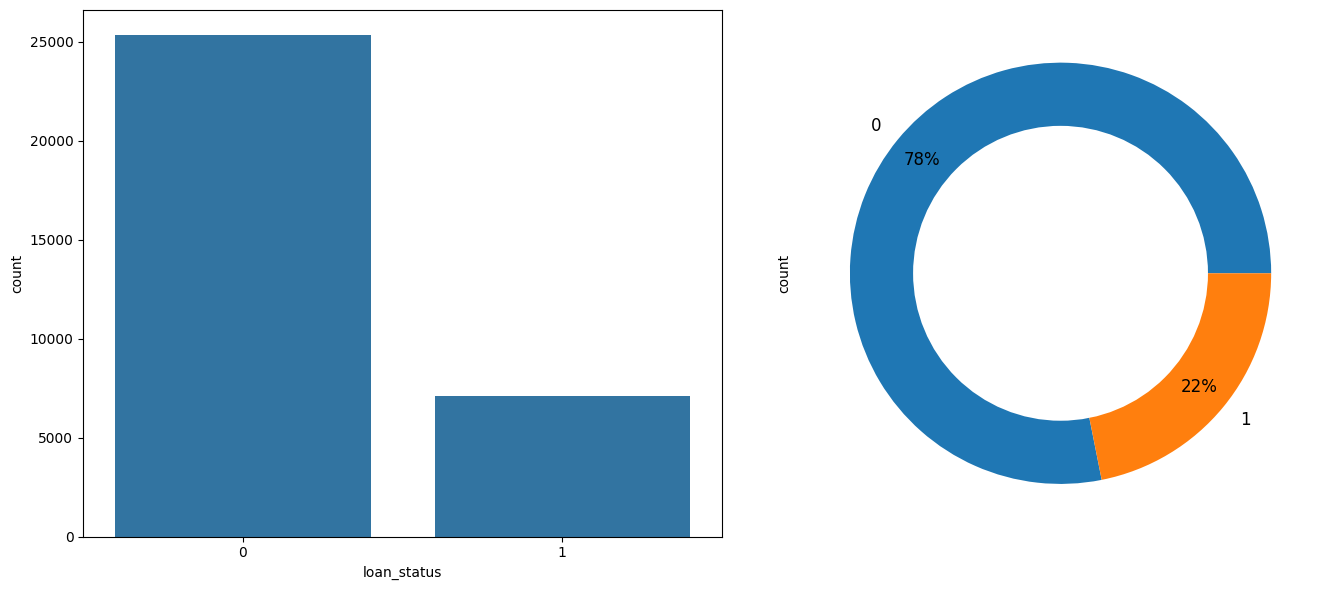

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.countplot(origin, x=target)

plt.subplot(1,2,2)
origin[target].value_counts().plot.pie(autopct='%.0f%%',pctdistance=0.85,fontsize=12)
plt.gca().add_artist(plt.Circle((0,0),radius=0.7,fc='white'))

plt.tight_layout()
plt.show()

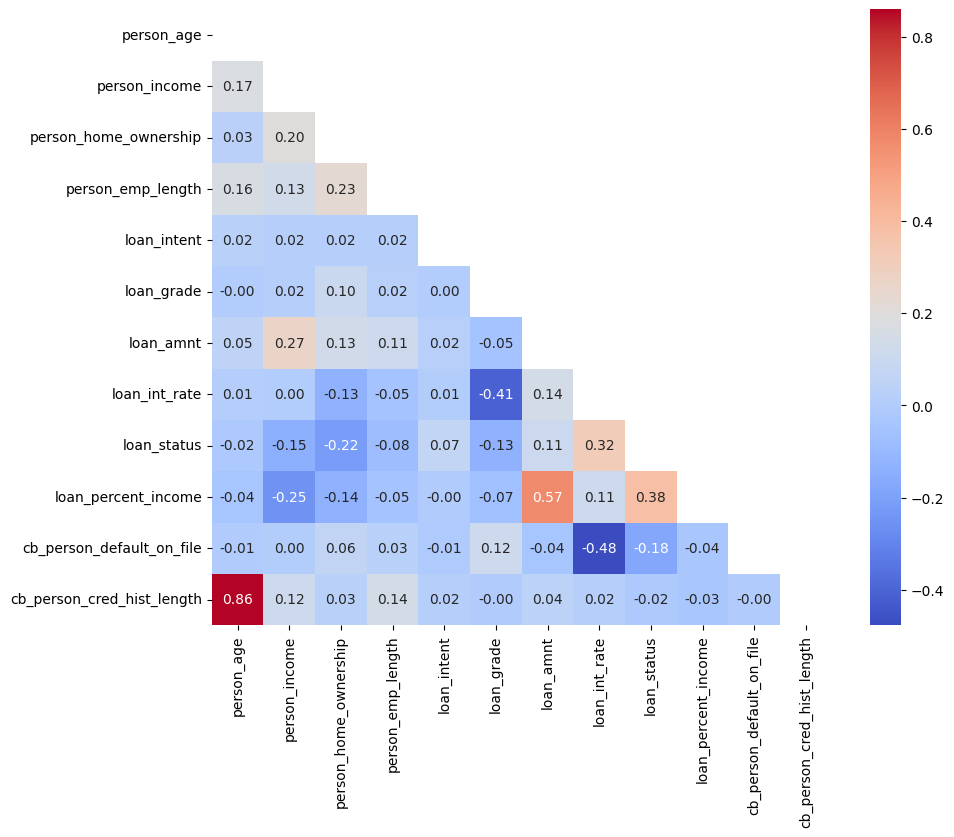

In [ ]:
train_new = origin.copy()

for col in categorical_features:
    train_new[col], _ = train_new[col].factorize()

cor_mat = train_new.corr()
mask = np.triu(cor_mat)

plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat, fmt='.2f', annot=True, mask=mask, cmap='coolwarm')
plt.show()

In [ ]:
origin.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [ ]:
origin.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
def convert_to_string(df):
    df_cat = df.copy()
    df_cat = df_cat.fillna(0)
    for col in features:
        df_cat[col] = df_cat[col].astype('string')
    return df_cat

In [ ]:
X_cat = convert_to_string(X)
test_cat = convert_to_string(test_df)

In [ ]:
X = train_df.drop(target, axis=1)
y = train_df[target].ravel()

In [ ]:
cat_params={
    'task_type'           : "CPU",
    'loss_function'       : 'Logloss',
    'eval_metric'         : "AUC",
    'bagging_temperature' : 0.25,
    'colsample_bylevel'   : 0.40,
    'iterations'          : 5_000,
    'learning_rate'       : 0.045,
    'max_depth'           : 7,
    'l2_leaf_reg'         : 0.80,
    'min_data_in_leaf'    : 30,
    'random_strength'     : 0.25,
    'random_state'        : 42,
    'early_stopping_rounds': 200,
    'use_best_model'       : True,
    'allow_writing_files' : False,
}

In [ ]:
 cat_clf = CatBoostClassifier(**cat_params)
    cat_clf = cat_clf.fit(X=X_train_pool,
                          eval_set=X_test_pool,
                          verbose=500,
                          early_stopping_rounds=200)

In [ ]:
 oof_train_preds[test_idx] = cat_clf.predict_proba(Pool(X_test, cat_features=features))[:, 1]

In [ ]:
test_pred = cat_clf.predict_proba(test_pool)[:, 1]

In [ ]:
auc = roc_auc_score(y_test, oof_train_preds[test_idx])

## postprocess

In [ ]:
import pandas as pd

In [ ]:
submission_1 = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/submission_1.csv')
submission_2 = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/submission_2.csv')
submission_3 = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/submission_3.csv')
submission_123 = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/submission123.csv')
submission_4 = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/submission_4.csv')
submission_7 = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/submission_7.csv')
submission_8 = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/submission_8.csv')
submission_9 = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/submission_9.csv')
submission_10 = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/submission_10.csv')


In [ ]:
# Install the kaggle API using
!pip install -q kaggle

In [ ]:
# Move the kaggle.json file into ~/.kaggle, which is where the API client expects your token to be located:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
sub1 = submission_10
sub2 = submission_4
sub3 = submission_1

sub1 = sub1.sort_values(by='id').reset_index(drop=True)
sub2 = sub2.sort_values(by='id').reset_index(drop=True)
sub3 = sub3.sort_values(by='id').reset_index(drop=True)

combined = pd.DataFrame({
    'id': sub1['id'],
    'loan_statusi_1': sub1['loan_status'],
    'loan_status_2': sub2['loan_status'],
    'loan_statusi_3': sub3['loan_status']
})

def majority_vote(row):
    return row.mode()[0]

combined['final_loan_status'] = combined[['loan_statusi_1', 'loan_status_2', 'loan_statusi_3']].apply(majority_vote, axis=1)

final_submission = combined[['id', 'final_loan_status']].rename(columns={'final_loan_status': 'loan_status'})

final_submission.to_csv('submission_10_4_1.csv', index=False)

print("Majority voting completed and saved to 'Final_Submission.csv'")

Majority voting completed and saved to 'Final_Submission.csv'


In [ ]:
!kaggle competitions submit -c playground-series-s4e10   -f submission_10_4_1.csv -m "submission_10_4_1"

100% 950k/950k [00:02<00:00, 436kB/s] 
Successfully submitted to Loan Approval Prediction

## autogluon

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Kaggle/lap

/content/drive/MyDrive/Kaggle/lap


In [ ]:
!kaggle datasets list

In [ ]:
!pip install dask[dataframe]

In [ ]:
!python -m pip install autogluon

In [ ]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/data/train_encor_with_ori.csv', index_col = 0)
test = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/data/test_encor.csv', index_col = 0)
target = 'loan_status'

In [ ]:
train

In [ ]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/data/train_encor_with_ori_v2.csv', index_col = 0)
test = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/data/test_encor.csv', index_col = 0)
target = 'loan_status'

In [ ]:
# 划分训练集和测试集
train, val = train_test_split(train, random_state=22, test_size=0.2)

In [ ]:
from autogluon.common import space
from scipy.stats import uniform


In [ ]:
from autogluon.common import space
from autogluon.features.generators import AutoMLPipelineFeatureGenerator
from autogluon.tabular import TabularDataset, TabularPredictor


metric = 'roc_auc'
#feature_prune_kwargs={"max_features_to_select":17 , "force_prune":True}
search_strategy = 'SKoptSearcher' # RLSearcher SKoptSearcher
#num_trials = 5
save_path = 'ful_v4'

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    #'num_trials': num_trials,
    'scheduler' : 'RLScheduler', # RLScheduler local
    'searcher': search_strategy,
}  # Refer to TabularPredictor.fit docstring for all valid values




predictor = TabularPredictor(target,
                            eval_metric=metric,
                            path=save_path,
                            problem_type='binary').fit(
                train,
                presets='best_quality', # medium_quality best_quality
                time_limit=3600 * 11,
                verbosity=2,
                ag_args_fit={'num_gpus': 1, 'num_cpus': 12}, # 'num_gpus': 1,
                #calibrate_decision_threshold=True,
                included_model_types=['XGB', 'CAT', 'GBM', 'FASTAI', 'XT'],
                #'auto_stack': True,
                #dynamic_stacking=True,
                #tuning_data=val,
                #num_bag_folds=5,
                #num_bag_sets=1,
                #num_stack_levels=1,
                #hyperparameters=self.hyperparameters,
                #feature_prune_kwargs=feature_prune_kwargs
                #hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
                #feature_generator=feature_generator,
            )


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
Memory Avail:       49.75 GB / 52.96 GB (93.9%)
Disk Space Avail:   60.65 GB / 100.00 GB (60.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stac

(_ray_fit pid=6678) [1000]	valid_set's binary_logloss: 0.175635


(_ray_fit pid=6861) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=6861) [1000]	valid_set's binary_logloss: 0.162882


(_ray_fit pid=7041) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=7041) [1000]	valid_set's binary_logloss: 0.162649


(_ray_fit pid=7235) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=7235) [1000]	valid_set's binary_logloss: 0.161409


(_ray_fit pid=7440) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=7440) [1000]	valid_set's binary_logloss: 0.16318


(_ray_fit pid=7628) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=7628) [1000]	valid_set's binary_logloss: 0.172199


(_ray_fit pid=7810) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=7810) [1000]	valid_set's binary_logloss: 0.16512


(_ray_fit pid=8008) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=8008) [1000]	valid_set's binary_logloss: 0.167017


(_dystack pid=5897) 	0.9507	 = Validation score   (roc_auc)
(_dystack pid=5897) 	193.22s	 = Training   runtime
(_dystack pid=5897) 	1.12s	 = Validation runtime
(_dystack pid=5897) Fitting model: LightGBM_BAG_L1 ... Training model for up to 6381.84s of the 9674.52s of remaining time.
(_dystack pid=5897) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (1 workers, per: cpus=12, gpus=1, memory=1.59%)
(_ray_fit pid=8205) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu
(_ray_fit pid=8347) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/Lig

(_ray_fit pid=8347) [1000]	valid_set's binary_logloss: 0.152459


(_ray_fit pid=8527) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu
(_ray_fit pid=8681) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=8681) [1000]	valid_set's binary_logloss: 0.154425


(_ray_fit pid=8853) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=8853) [1000]	valid_set's binary_logloss: 0.154343


(_ray_fit pid=9049) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu
(_ray_fit pid=9199) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu
(_ray_fit pid=9341) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninsta

(_ray_fit pid=21586) [1000]	valid_set's binary_logloss: 0.168283
(_ray_fit pid=21586) [2000]	valid_set's binary_logloss: 0.166931


(_ray_fit pid=21861) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=21861) [1000]	valid_set's binary_logloss: 0.153685
(_ray_fit pid=21861) [2000]	valid_set's binary_logloss: 0.151781


(_ray_fit pid=22154) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=22154) [1000]	valid_set's binary_logloss: 0.154019
(_ray_fit pid=22154) [2000]	valid_set's binary_logloss: 0.1519
(_ray_fit pid=22154) [3000]	valid_set's binary_logloss: 0.152419


(_ray_fit pid=22454) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=22454) [1000]	valid_set's binary_logloss: 0.154245
(_ray_fit pid=22454) [2000]	valid_set's binary_logloss: 0.15185


(_ray_fit pid=22710) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=22710) [1000]	valid_set's binary_logloss: 0.155976
(_ray_fit pid=22710) [2000]	valid_set's binary_logloss: 0.15353


(_ray_fit pid=23002) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=23002) [1000]	valid_set's binary_logloss: 0.163706


(_ray_fit pid=23306) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=23306) [1000]	valid_set's binary_logloss: 0.158109
(_ray_fit pid=23306) [2000]	valid_set's binary_logloss: 0.15653


(_ray_fit pid=23602) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=23602) [1000]	valid_set's binary_logloss: 0.161505
(_ray_fit pid=23602) [2000]	valid_set's binary_logloss: 0.160453


(_dystack pid=5897) 	0.9584	 = Validation score   (roc_auc)
(_dystack pid=5897) 	384.79s	 = Training   runtime
(_dystack pid=5897) 	2.27s	 = Validation runtime
(_dystack pid=5897) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 4206.92s of the 7499.61s of remaining time.
(_dystack pid=5897) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (1 workers, per: cpus=12, gpus=1, memory=2.54%)
(_dystack pid=5897) 	0.9252	 = Validation score   (roc_auc)
(_dystack pid=5897) 	865.5s	 = Training   runtime
(_dystack pid=5897) 	1.94s	 = Validation runtime
(_dystack pid=5897) Fitting model: CatBoost_r9_BAG_L1 ... Training model for up to 3338.86s of the 6631.55s of remaining time.
(_dystack pid=5897) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (1 workers, per: cpus=12, gpus=1, memory=2.45%)
(_ray_fit pid=28298) 	Warning: CatBoost on GPU is experimental. If you encounter issues, use CPU for training 

(_ray_fit pid=30621) [1000]	valid_set's binary_logloss: 0.185273
(_ray_fit pid=30621) [2000]	valid_set's binary_logloss: 0.179923
(_ray_fit pid=30621) [3000]	valid_set's binary_logloss: 0.177674
(_ray_fit pid=30621) [4000]	valid_set's binary_logloss: 0.176287
(_ray_fit pid=30621) [5000]	valid_set's binary_logloss: 0.175432
(_ray_fit pid=30621) [6000]	valid_set's binary_logloss: 0.174696
(_ray_fit pid=30621) [7000]	valid_set's binary_logloss: 0.174526
(_ray_fit pid=30621) [8000]	valid_set's binary_logloss: 0.174404
(_ray_fit pid=30621) [9000]	valid_set's binary_logloss: 0.174798
(_ray_fit pid=30621) [10000]	valid_set's binary_logloss: 0.175123


(_ray_fit pid=31418) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=31418) [1000]	valid_set's binary_logloss: 0.172215
(_ray_fit pid=31418) [2000]	valid_set's binary_logloss: 0.167144
(_ray_fit pid=31418) [3000]	valid_set's binary_logloss: 0.165021
(_ray_fit pid=31418) [4000]	valid_set's binary_logloss: 0.163462
(_ray_fit pid=31418) [5000]	valid_set's binary_logloss: 0.162603
(_ray_fit pid=31418) [6000]	valid_set's binary_logloss: 0.162178
(_ray_fit pid=31418) [7000]	valid_set's binary_logloss: 0.162035
(_ray_fit pid=31418) [8000]	valid_set's binary_logloss: 0.162043
(_ray_fit pid=31418) [9000]	valid_set's binary_logloss: 0.162465


(_ray_fit pid=31858) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=31858) [1000]	valid_set's binary_logloss: 0.17344
(_ray_fit pid=31858) [2000]	valid_set's binary_logloss: 0.167631
(_ray_fit pid=31858) [3000]	valid_set's binary_logloss: 0.165156
(_ray_fit pid=31858) [4000]	valid_set's binary_logloss: 0.163602
(_ray_fit pid=31858) [5000]	valid_set's binary_logloss: 0.162626
(_ray_fit pid=31858) [6000]	valid_set's binary_logloss: 0.162106
(_ray_fit pid=31858) [7000]	valid_set's binary_logloss: 0.161823
(_ray_fit pid=31858) [8000]	valid_set's binary_logloss: 0.16198
(_ray_fit pid=31858) [9000]	valid_set's binary_logloss: 0.16207


(_ray_fit pid=32325) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=32325) [1000]	valid_set's binary_logloss: 0.173546
(_ray_fit pid=32325) [2000]	valid_set's binary_logloss: 0.167865
(_ray_fit pid=32325) [3000]	valid_set's binary_logloss: 0.165072
(_ray_fit pid=32325) [4000]	valid_set's binary_logloss: 0.163163
(_ray_fit pid=32325) [5000]	valid_set's binary_logloss: 0.161927
(_ray_fit pid=32325) [6000]	valid_set's binary_logloss: 0.161223
(_ray_fit pid=32325) [7000]	valid_set's binary_logloss: 0.160667
(_ray_fit pid=32325) [8000]	valid_set's binary_logloss: 0.160414
(_ray_fit pid=32325) [9000]	valid_set's binary_logloss: 0.1604
(_ray_fit pid=32325) [10000]	valid_set's binary_logloss: 0.1603


(_ray_fit pid=32774) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=32774) [1000]	valid_set's binary_logloss: 0.172876
(_ray_fit pid=32774) [2000]	valid_set's binary_logloss: 0.167185
(_ray_fit pid=32774) [3000]	valid_set's binary_logloss: 0.164604
(_ray_fit pid=32774) [4000]	valid_set's binary_logloss: 0.163064
(_ray_fit pid=32774) [5000]	valid_set's binary_logloss: 0.162061
(_ray_fit pid=32774) [6000]	valid_set's binary_logloss: 0.1614
(_ray_fit pid=32774) [7000]	valid_set's binary_logloss: 0.161094
(_ray_fit pid=32774) [8000]	valid_set's binary_logloss: 0.161142
(_ray_fit pid=32774) [9000]	valid_set's binary_logloss: 0.161309


(_ray_fit pid=33519) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=33519) [1000]	valid_set's binary_logloss: 0.181357
(_ray_fit pid=33519) [2000]	valid_set's binary_logloss: 0.17577
(_ray_fit pid=33519) [3000]	valid_set's binary_logloss: 0.173197
(_ray_fit pid=33519) [4000]	valid_set's binary_logloss: 0.172073
(_ray_fit pid=33519) [5000]	valid_set's binary_logloss: 0.171128
(_ray_fit pid=33519) [6000]	valid_set's binary_logloss: 0.170652
(_ray_fit pid=33519) [7000]	valid_set's binary_logloss: 0.170659
(_ray_fit pid=33519) [8000]	valid_set's binary_logloss: 0.170691


(_ray_fit pid=34225) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=34225) [1000]	valid_set's binary_logloss: 0.173685
(_ray_fit pid=34225) [2000]	valid_set's binary_logloss: 0.168436
(_ray_fit pid=34225) [3000]	valid_set's binary_logloss: 0.166786
(_ray_fit pid=34225) [4000]	valid_set's binary_logloss: 0.165651
(_ray_fit pid=34225) [5000]	valid_set's binary_logloss: 0.165004
(_ray_fit pid=34225) [6000]	valid_set's binary_logloss: 0.164802
(_ray_fit pid=34225) [7000]	valid_set's binary_logloss: 0.164682
(_ray_fit pid=34225) [8000]	valid_set's binary_logloss: 0.164728
(_ray_fit pid=34225) [9000]	valid_set's binary_logloss: 0.164822


(_ray_fit pid=34679) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=34679) [1000]	valid_set's binary_logloss: 0.176165
(_ray_fit pid=34679) [2000]	valid_set's binary_logloss: 0.171219
(_ray_fit pid=34679) [3000]	valid_set's binary_logloss: 0.169063
(_ray_fit pid=34679) [4000]	valid_set's binary_logloss: 0.167752
(_ray_fit pid=34679) [5000]	valid_set's binary_logloss: 0.167129
(_ray_fit pid=34679) [6000]	valid_set's binary_logloss: 0.166645
(_ray_fit pid=34679) [7000]	valid_set's binary_logloss: 0.16678


(_dystack pid=5897) 	0.9515	 = Validation score   (roc_auc)
(_dystack pid=5897) 	909.8s	 = Training   runtime
(_dystack pid=5897) 	5.82s	 = Validation runtime
(_dystack pid=5897) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 2237.48s of the 5530.16s of remaining time.
(_dystack pid=5897) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (1 workers, per: cpus=12, gpus=1, memory=3.78%)
(_ray_fit pid=35067) /usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:01:20] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
(_ray_fit pid=35067)   warnings.warn(smsg, UserWarning)
(_ray_fit pid=35067) /usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:01:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA i

(_ray_fit pid=72354) [1000]	valid_set's binary_logloss: 0.155445


(_ray_fit pid=72530) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu
(_ray_fit pid=72678) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu
(_ray_fit pid=72820) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip unin

(_ray_fit pid=72820) [1000]	valid_set's binary_logloss: 0.153788


(_ray_fit pid=72991) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu
(_ray_fit pid=73143) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=73143) [1000]	valid_set's binary_logloss: 0.159576


(_ray_fit pid=73305) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu
(_ray_fit pid=73465) Warning: GPU mode might not be installed for LightGBM, GPU training raised an exception. Falling back to CPU training...Refer to LightGBM GPU documentation: https://github.com/Microsoft/LightGBM/tree/master/python-package#build-gpu-versionOne possible method is:	pip uninstall lightgbm -y	pip install lightgbm --install-option=--gpu


(_ray_fit pid=73465) [1000]	valid_set's binary_logloss: 0.148106


(_dystack pid=5897) 	0.96	 = Validation score   (roc_auc)
(_dystack pid=5897) 	129.66s	 = Training   runtime
(_dystack pid=5897) 	0.73s	 = Validation runtime
(_dystack pid=5897) Fitting model: XGBoost_r33_BAG_L2 ... Training model for up to 844.77s of the 844.6s of remaining time.
(_dystack pid=5897) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (1 workers, per: cpus=12, gpus=1, memory=4.07%)
(_ray_fit pid=73641) /usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:19:26] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
(_ray_fit pid=73641)   warnings.warn(smsg, UserWarning)
(_ray_fit pid=73641) /usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:19:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA inste

## summery

In [ ]:
predictor.leaderboard(extra_info=True)

In [ ]:
predictor.leaderboard(silent=True).style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.961635,roc_auc,184.616093,21178.358305,0.014744,8.863626,3,True,84
1,CatBoost_r9_BAG_L2,0.961182,roc_auc,143.095630,19646.917521,0.435315,88.568948,2,True,59
2,LightGBM_r131_BAG_L2,0.961109,roc_auc,143.385622,19758.522937,0.725307,200.174363,2,True,57
3,XGBoost_r89_BAG_L2,0.961087,roc_auc,144.306738,19609.664620,1.646422,51.316047,2,True,68
4,LightGBM_r96_BAG_L2,0.961062,roc_auc,143.757909,19753.437660,1.097594,195.089087,2,True,60
5,LightGBM_r161_BAG_L2,0.960965,roc_auc,143.579101,19897.960112,0.918785,339.611539,2,True,76
6,XGBoost_BAG_L2,0.960941,roc_auc,144.403527,19608.955328,1.743212,50.606755,2,True,54
7,CatBoost_r70_BAG_L2,0.960914,roc_auc,143.028579,19624.775008,0.368263,66.426434,2,True,78
8,CatBoost_r13_BAG_L2,0.960876,roc_auc,142.974860,19794.723880,0.314544,236.375307,2,True,65
9,XGBoost_r33_BAG_L2,0.960840,roc_auc,144.442352,19658.645967,1.782036,100.297393,2,True,61


In [ ]:
results = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val eval_metric  pred_time_val      fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3   0.961635     roc_auc     184.616093  21178.358305                0.014744           8.863626            3       True         84
1            CatBoost_r9_BAG_L2   0.961182     roc_auc     143.095630  19646.917521                0.435315          88.568948            2       True         59
2          LightGBM_r131_BAG_L2   0.961109     roc_auc     143.385622  19758.522937                0.725307         200.174363            2       True         57
3            XGBoost_r89_BAG_L2   0.961087     roc_auc     144.306738  19609.664620                1.646422          51.316047            2       True         68
4           LightGBM_r96_BAG_L2   0.961062     roc_auc     143.757909  19753.437660                1.097594         195.089087  

In [ ]:
predictor.evaluate(val_data)

In [ ]:
predictor.feature_importance(val_data)
# test_data

In [ ]:
preds = predictor.predict(test)

## submit 15

In [ ]:
# Install the kaggle API using
!pip install -q kaggle

In [ ]:
# Move the kaggle.json file into ~/.kaggle, which is where the API client expects your token to be located:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [ ]:
import pandas as pd

In [ ]:
pred_proba = predictor.predict_proba(test)

# Use probability for the positive class (loan approved, i.e., class 1)
pred_15 = pred_proba[1]

pred_15.to_csv('pred_15.csv', index=False)

In [ ]:
preds = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/pred_15.csv')

In [ ]:
preds

In [ ]:
submission_15 = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/data/sample_submission.csv')
submission_15['loan_status'] = preds

In [ ]:
submission_15.to_csv('submission_15.csv', index=False)

In [ ]:
!kaggle competitions submit -c playground-series-s4e10   -f submission19.csv -m "submission18"

100% 997k/997k [00:00<00:00, 4.41MB/s]
400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (5) today, please try again tomorrow UTC (3.7 hours from now).


In [ ]:
predictor.path  # The path on disk where the predictor is saved
'AutogluonModels/ag-20241026_041940'

In [ ]:
/content/drive/MyDrive/Kaggle/lap/params_ka2/models/LightGBM_2_BAG_L1

In [ ]:
/content/drive/MyDrive/Kaggle/lap/params_ka2/models/XGBoost_r89_2_BAG_L1

In [ ]:
/content/drive/MyDrive/Kaggle/lap/params_ka2/models/CatBoost_r9_2_BAG_L1

In [ ]:
predictor = TabularPredictor.load(/content/drive/MyDrive/Kaggle/lap/params_ka2/models/LightGBM_2_BAG_L1)

In [ ]:
import pandas as pd

In [ ]:
submission_14 = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/submission_14.csv')
submission_15 = pd.read_csv('/content/drive/MyDrive/Kaggle/lap/submission_15.csv')

In [ ]:
submission19 = submission_14.copy()
submission19["loan_status"] = (submission_14["loan_status"]*0.7 + submission_15["loan_status"]*0.3)

# 保存融合后的文件
submission19.to_csv("submission19.csv", index=False)